Задание: Дан граф текста, множество вершин совпадает со словарем текста, связи являются взвешенными и показывают, как часто два слова находились в одном окне длины N. Найти слова с наибольшей мерой посредничества.
1) Были скачаны необходимые пакеты Python для работы с лабораторной.
2) Была поставлена следующая **гипотеза:** слова, образующие самые тяжелые связи в графе, скорее всего, представляют собой устойчивые конструкции или фразеологизмы, либо просто часто употребляются вместе.

In [1]:
!pip install requests
!pip install bs4
!pip install fake_useragent
!pip install pandas
!pip install matplotlib
!pip install networkx
!pip install scipy
!pip install pymorphy2



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Импортируем все необходимые библиотеки
import requests 
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from tqdm import tqdm
from collections import defaultdict
import networkx as nx
import re
import matplotlib.pyplot as plt
import pymorphy2
import string
from typing import List, Dict

In [181]:
# Словарь для преобразования названия месяца в число
months = {
    'января': '01',
    'февраля': '02',
    'марта': '03',
    'апреля': '04',
    'мая': '05',
    'июня': '06',
    'июля': '07',
    'августа': '08',
    'сентября': '09',
    'октября': '10',
    'ноября': '11',
    'декабря': '12'
}


В данной функции осуществляется извлечение информации о новостях города Кирова, включая время публикации, автора, заголовок новости, URL , содержание текста статьи и т.д. Процесс парсинга занял около 7 часов, в результате чего было собрано около 111 000 новостей. После этого все новости были отформатированы в соответствии с требуемым форматом, который включает разделители(=====), URL, название источника, время публикации, автора, заголовок статьи и текст новости.

In [182]:
# Функция для извлечения информации из новостей (даты, текста, заголовка и т.п.)
def get_news_info(num):
    news_url = f'https://progorod43.ru/news/{num}'
    response = requests.get(news_url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Извлекаем заголовок новости
    title_tag = soup.find('h1', {'itemprop': 'headline'})
    title = title_tag.text.strip() if title_tag else ""

    # Извлекаем информацию об авторе новости
    author_info = soup.find('a', {'class': 'article-info_articleInfoAuthor__W0ZnW'})
    author = author_info.text.strip() if author_info else ""

    # Извлекаем информацию о дате публикации новости
    datetime_info = soup.find('li', {'class': 'article-info_articleInfoItem__1qSY9'})
    publication_date = datetime_info.text.strip() if datetime_info else ""

    # Обработка даты
    if publication_date != "":
        try:
            # Примерный формат: 18 июня 2008 или 18 июня 12:34 для текущего года
            date_parts = publication_date.split()
            if len(date_parts[2]) == 4:
                day, month, year = date_parts
                month_number = months.get(month, '01')  # Преобразование месяца в число
                publication_date = f"{year}.{month_number}.{day}"
            else:
                day, month, time = date_parts
                month_number = months.get(month, '01')
                year = '2024'  # Присваиваем 2024 год, если года нет
                publication_date = f"{year}.{month_number}.{day}"
        except Exception as e:
            publication_date = ""

                # Извлекаем текст новости, исключая ненужные части
    news_body = soup.find('div', {'class': 'article-body_articleBody__fiSBh', 'itemprop': 'articleBody', 'id': 'articleBody'})
    if news_body:
        for social_part in news_body.find_all('div', {'class': 'social-list-subscribe_socialListSubscribe__XrTI7 article-body_articleBodySocialListSubcribe__4Zj9a'}):
            social_part.decompose()  # Удаляем ненужную часть
        for title_part in news_body.find_all('h1', {'itemprop': 'headline'}):
          title_part.decompose()

        # Удаляем информацию об авторе
        for author_part in news_body.find_all('a', {'class': 'article-info_articleInfoAuthor__W0ZnW'}):
            author_part.decompose()

        # Удаляем информацию о дате публикации
        for date_part in news_body.find_all('li', {'class': 'article-info_articleInfoItem__1qSY9'}):
            date_part.decompose()
        news_text = news_body.get_text(separator="").strip()
    else:
        news_text = ""

    # Название источника
    source_name = "Про Город"

    # Форматируем вывод
    formatted_text = (f"=====\n"
                      f"{news_url}\n"
                      f"{source_name}\n"
                      f"{publication_date}\n"
                      f"{author}\n"
                      f"{title}\n\n"
                      f"{news_text}\n")

    return formatted_text


In [184]:
output_file_path = "Progorod.txt"  # Имя файла для сохранения новостей

# Открываем файл для записи каждой статьи
print('Начинаю сохранять...')
# Используем tqdm для визуализации прогресса выполнения
for number in tqdm(range(1, 111000)):    
    with open(output_file_path, 'a', encoding='utf-8') as output_file:
        output_file.write(get_news_info(number))
print('готово!')


Ключевая цель двух последующих функций заключается в извлечении текста новостей из спарсенных данных, последующей очистке от знаков препинания и лемматизации. Этот процесс необходим для создания качественного словаря связей между словами с учетом заданного окна длины N. 

In [4]:

# Очищаем текст новостей от всех знаков препинания
cleaned_news_texts = []


file_path = 'Progorod.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    articles = f.read().split('=====\n')

for article in articles:
    # Разделяем текст статьи по новой строке, ограничивая количество разделений до 5
    # Берем последнюю часть после разделения (текст статьи)
    text = article.split('\n', maxsplit=5)[-1].strip()
    if text:  
        cleaned_text = re.sub(r'[^\w\s]', '', text)  # Удаляем все знаки препинания
        cleaned_news_texts.append(cleaned_text)
        if len(cleaned_news_texts) >= 1000:  # Ограничение до 1000 новостей
            break



In [5]:
# Функция для лемматизации текста
def lemmatize_text(text: str) -> List[str]:
    morph = pymorphy2.MorphAnalyzer()
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return lemmatized_words


В данной функции для каждого слова обрисовываются границы, в которых лежат его соседи. Слово + сосед лежат в окне N, значит расстояние между словом и соседом не больше N-1, а значит границы соседей для конкретного текущего слова от i - (N-1) до i + (N-1). 

In [6]:
# Функция для построения словаря связей с окном N
def build_word_dict(texts: Dict[str, Dict[str, int]], window_size: int) -> Dict[str, Dict[str, int]]:
    # Инициализация словаря для хранения связей между словами
    word_dict = defaultdict(lambda: defaultdict(int))
    for text in texts:
        words = lemmatize_text(text)
        for index in range(len(words)):

            # Поскольку мы рассматриваем все пары слов в окне длины N, для
            # каждого текущего слова определяем границы, в пределах которых могут находиться его соседи.
            # Эти границы задаются так, чтобы расстояние от начала или конца окна до текущего слова не превышало N-1, 
            # обеспечивая, что и текущее слово, и его соседи находятся в пределах окна длины N.
            start_index = max(0, index - window_size + 1)
            end_index = min(len(words), index + window_size - 1)
            # Проходим по соседним словам в заданном окне
            for neighbor_index in range(start_index, end_index):
                # Проверяем, что соседнее слово не совпадает с текущим
                if words[neighbor_index] != words[index]:
                    neighbor_word = words[neighbor_index]
                    # Увеличиваем счетчик связей между текущим словом и его соседом
                    word_dict[words[index]][words[neighbor_index]] += 1
    return word_dict


In [7]:
N = 5 

# Построение словаря связей
word_dict = build_word_dict(cleaned_news_texts, N)

# Построение графа
G = nx.Graph()
for word, neighbors in word_dict.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(word, neighbor, weight=weight)

**Betweenness centrality** - доля кратчайших путей в графе, которые проходят через данную вершину.
 Данная часть кода вычисляет меру посредничества (betweenness centrality) для каждой вершины в графе G, используя веса ребер, заданные как weight. Мера посредничества показывает долю всех кратчайших путей в графе, которые проходят через каждую вершину. Далее все сортируется по убыванию, и выводится десять вершин с наибольшим значением посредничества.

In [199]:
betweenness = nx.betweenness_centrality(G, weight='weight')

# Сортировка слов по мере посредничества
sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]



[('и', 0.09108795488604657),
 ('в', 0.08768440582108422),
 ('на', 0.05253966780649934),
 ('с', 0.037990370925456894),
 ('быть', 0.026408610685091684),
 ('не', 0.02606354875752047),
 ('по', 0.024727595074762954),
 ('из', 0.018874971922303654),
 ('а', 0.01652151607845876),
 ('что', 0.015781563032708983)]

А теперь вернемся к моей гипотезе. В этой части кода я искала самые тяжелые связи между словами, чтобы доказать ранее поставленную гипотезу. Могу сказать, что она подтвердилась лишь частично, потому что здесь нет устойчивых лексико-грамматических единиц (УЛГЕ), но можно заметить слова, которые часто употребляются вместе в различных контекстах. Для доказательной базы можно посмотреть в основной НКРЯ и сравнить, сколько раз эти слова употребляются вместе: ('в', 'и') — около 10 000 000, ('в', 'на') — около 3 000 000, ('и', 'на') — 5 124 537, ('в', 'год') — 98 261, ('в', 'быть') — 311 575, ('в', 'с') — 2 916 479, ('в', 'Киров') — в данном случае новости про город Киров, следовательно, очевидно, почему данные слова так часто встречались вместе, ('в', 'город') — 298 277, ('в', 'не') — 3 660 786, ('в', 'это') — 924 286.

На основе этих данных можно сделать вывод, что гипотеза подтверждена лишь наполовину. Действительно, самые часто употребляемые вместе слова образуют наиболее тяжелые связи. Однако часть гипотезы об устойчивых конструкциях не подтвердилась, возможно, из-за того, что сайт является новостным, хотя точная причина не до конца ясна.

In [8]:
# Найти топ-10 тяжелых связей
top_heavy_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

# Вывести топ-10 тяжелых связей
print("Топ-10 тяжелых связей:")
for edge in top_heavy_edges:
    print(edge[:2],"—",edge[2]['weight'])

Топ-10 тяжелых связей:
('в', 'и') — 970
('в', 'на') — 797
('и', 'на') — 619
('в', 'год') — 509
('в', 'быть') — 450
('в', 'с') — 433
('в', 'киров') — 417
('в', 'город') — 402
('в', 'не') — 390
('в', 'это') — 377


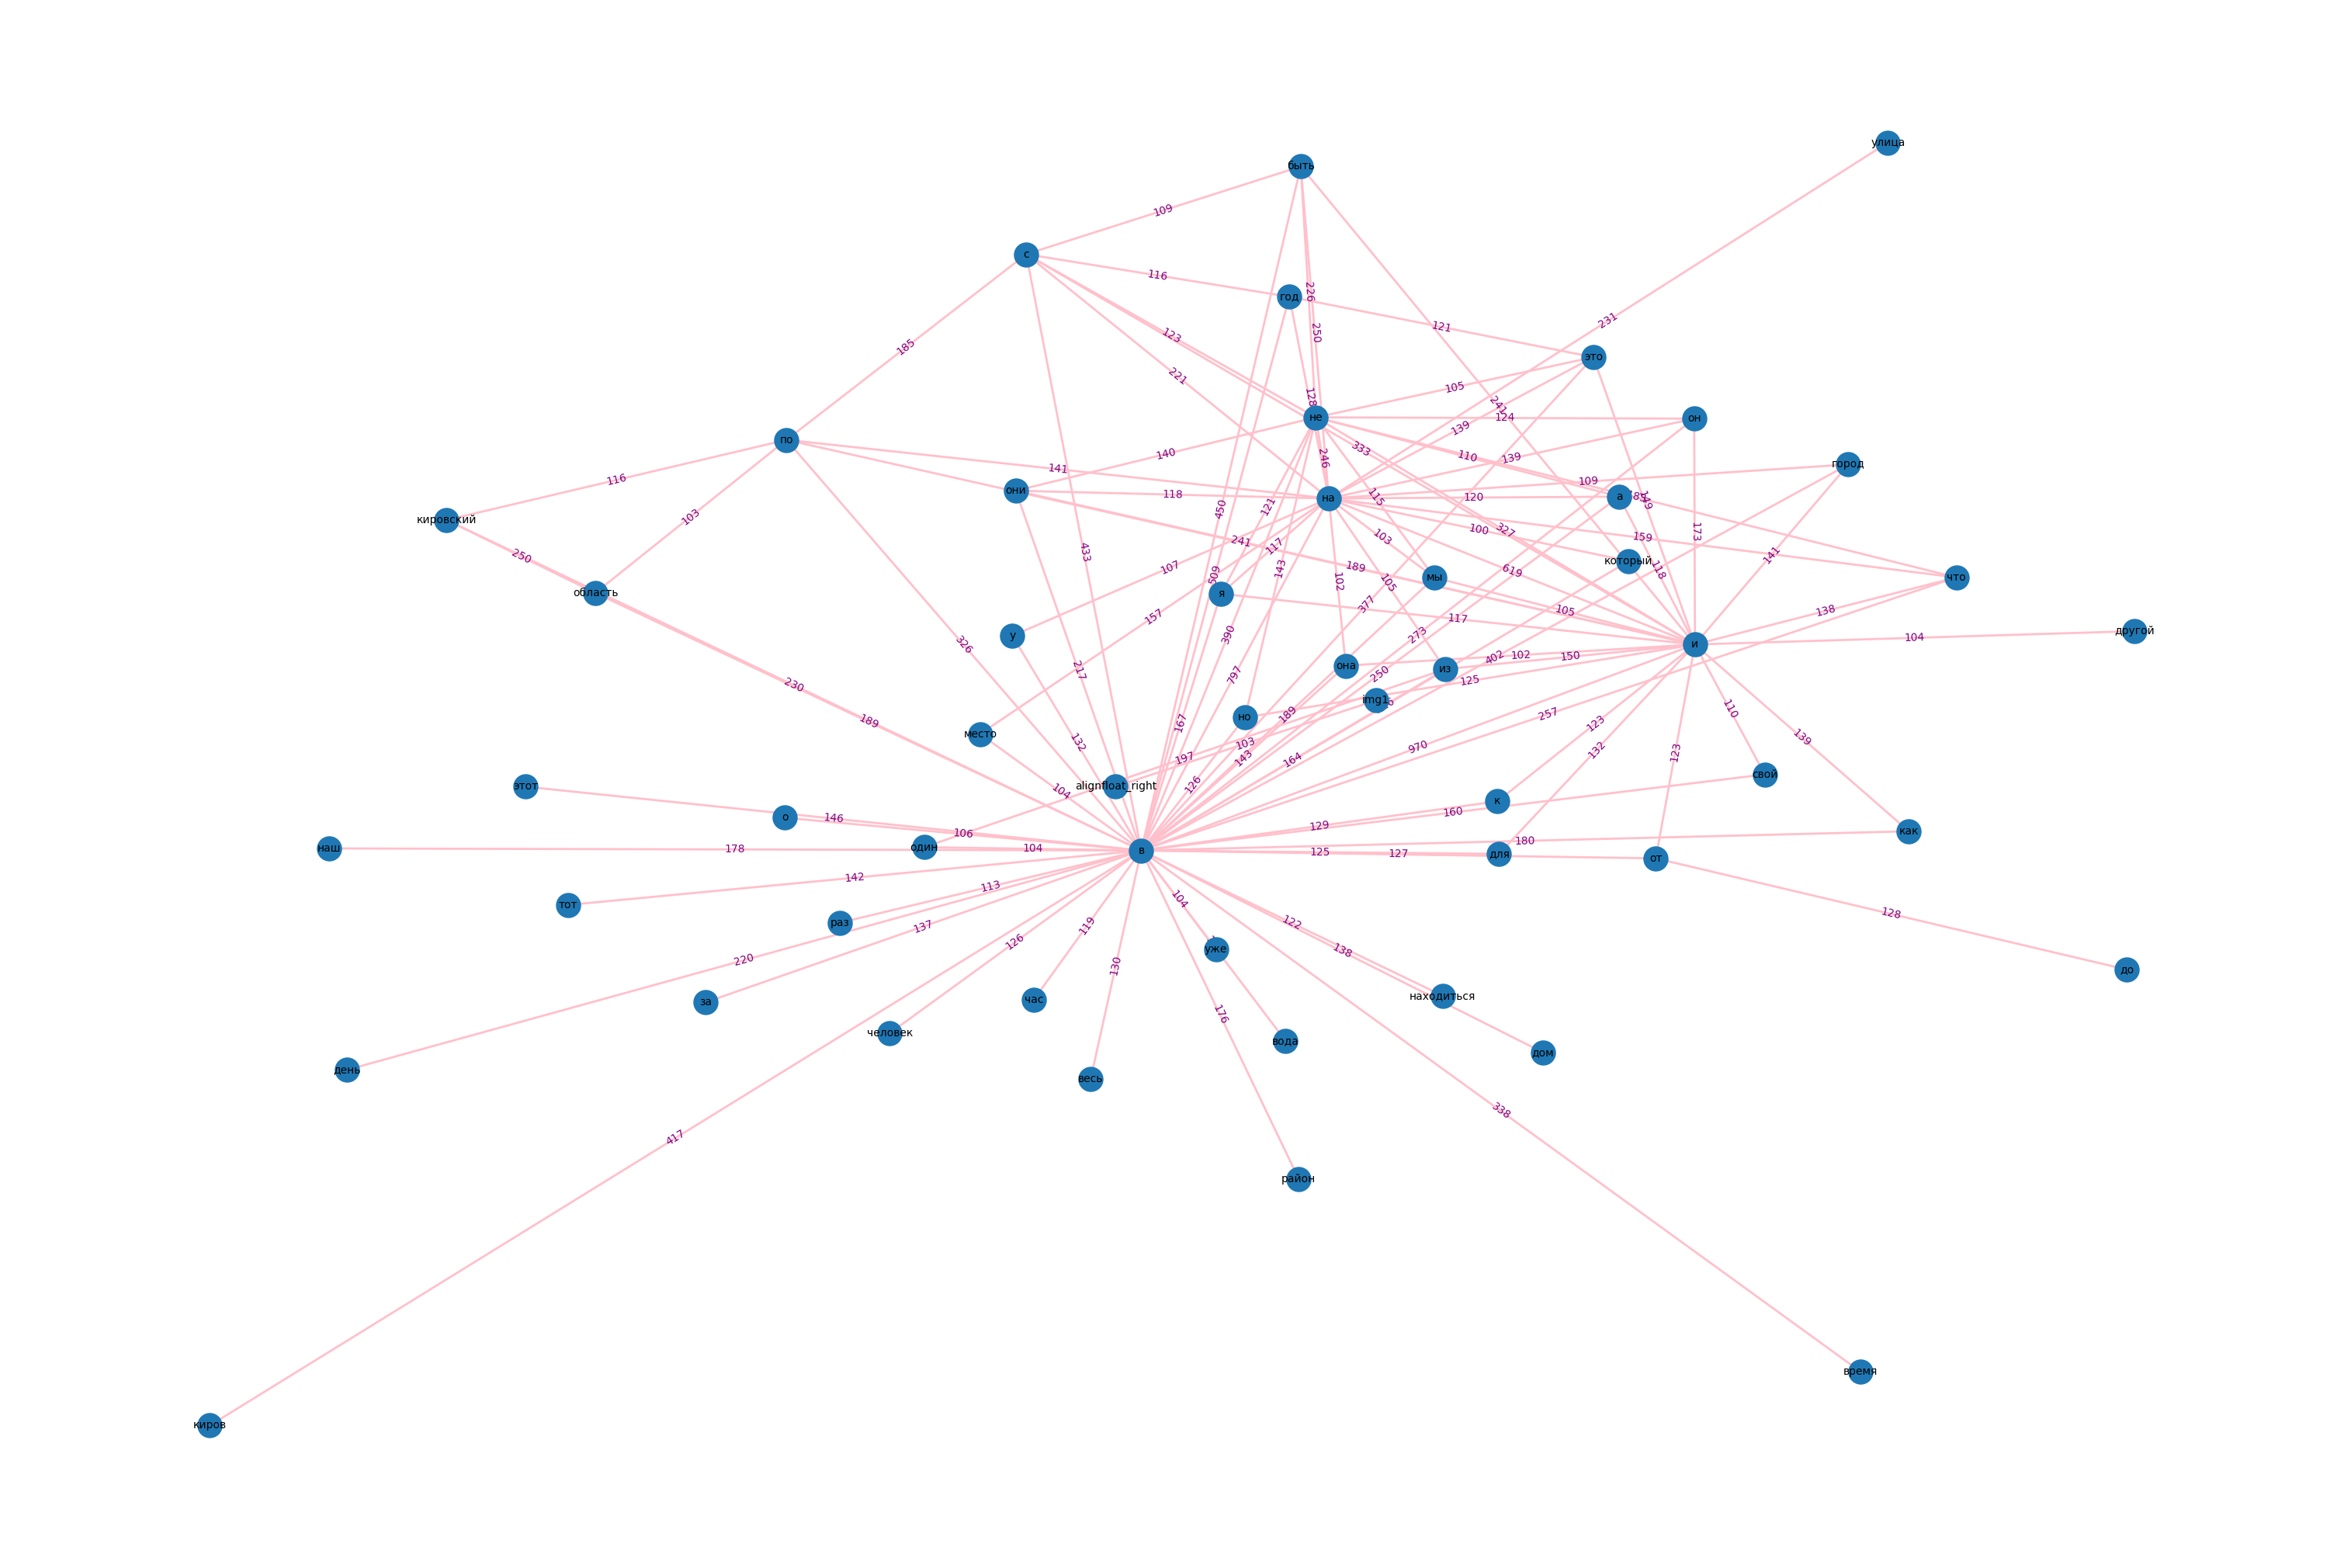

In [216]:
# Cтроим взвешенный граф

threshold = 100 # Пороговое значение для веса рёбер

# Создайте подграф с рёбрами, вес которых больше или равен порогу
filtered_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= threshold]

# Создаем подграф на основе отфильтрованных рёбер
subgraph = G.edge_subgraph(filtered_edges)


plt.figure(figsize=(30, 20))  
pos = nx.kamada_kawai_layout(subgraph)  # Выбираем алгоритм для расположения узлов
nx.draw(subgraph, pos, with_labels=True, node_size=500, font_size=10, font_color='black', edge_color='pink', width=2)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='purple', bbox=dict(alpha=0))  # Рисуем подписи рёбер
plt.show()
